# Rice Yield Prediction: PyTorch Neural Network with Optuna Tuning

## Overview
This notebook trains a **Feed-Forward Neural Network (MLP)** using **PyTorch** to predict Rice yields.

## Methodology
1.  **Feature Analysis:** Displaying used features.
2.  **Time-Series Split (Consistency Check):**
    * **Train (< 2016):** Model learning.
    * **Validation (2016 - 2020):** Hyperparameter tuning and early stopping.
    * **Test (>= 2020):** Final unseen evaluation.
3.  **Preprocessing:** Standard Scaling and Imputation (Crucial for Neural Networks).
4.  **Baseline:** Naive approach (Last Year's Yield).
5.  **Initial Model:** Training a default Neural Network and plotting the **Learning Curve** (RMSE vs Epochs).
6.  **Optimization:** Using **Optuna** to find the best architecture (Layers, Units, Dropout, LR, Batch Size).
7.  **Final Evaluation:** Comparing RMSE and R2 across all stages.

In [1]:
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance

# PyTorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Optuna Visualization Tools
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_slice
from optuna.visualization import plot_param_importances

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

/Users/pavin/Documents/GitHub/ML_project/.venv-1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


### 1. Data Loading

In [2]:
# Load dataset
df = pd.read_parquet('Parquet/XY_version1.parquet')

# Define Target
TARGET_COL = 'Y_rice'
LAG_1_FEATURE = 'avg_yield_rice_1y'

# Clean Missing Targets
df_model = df.dropna(subset=[TARGET_COL])

print("Data Loaded Successfully.")

Data Loaded Successfully.


### 2. Feature Selection, Preprocessing & Data Split
Neural Networks require scaled input data. We split the data, impute missing values, scale features, and convert them to PyTorch Tensors.

In [3]:
# --- FEATURE SELECTION ---
# Select independent variables (exclude 'Y_' columns and metadata)
feature_cols = [c for c in df_model.columns if not c.startswith('Y_') and c not in ['year', 'area']]

# --- DISPLAY FEATURES TABLE ---
print(f"Total Features Used: {len(feature_cols)}")
print("-" * 30)
# Create a clean dataframe to display features horizontally for the report
feature_preview = pd.DataFrame(feature_cols, columns=['Feature Name']).T
display(feature_preview)

# --- TIME-SERIES SPLIT ---
TRAIN_END_YEAR = 2016
VAL_END_YEAR = 2020

# 1. Training Set (< 2016)
mask_train = df_model['year'] < TRAIN_END_YEAR
X_train_raw = df_model[mask_train][feature_cols]
y_train_raw = df_model[mask_train][TARGET_COL].values.reshape(-1, 1)

# 2. Validation Set (>= 2016 and < 2020)
mask_val = (df_model['year'] >= TRAIN_END_YEAR) & (df_model['year'] < VAL_END_YEAR)
X_val_raw = df_model[mask_val][feature_cols]
y_val_raw = df_model[mask_val][TARGET_COL].values.reshape(-1, 1)

# 3. Test Set (>= 2020)
mask_test = df_model['year'] >= VAL_END_YEAR
X_test_raw = df_model[mask_test][feature_cols]
y_test_raw = df_model[mask_test][TARGET_COL].values.reshape(-1, 1)

# --- PREPROCESSING (Imputation + Scaling) ---
print("\nPreprocessing: Imputing missing values and Scaling data...")
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

# Fit on Train, Transform on Val/Test to prevent leakage
X_train_np = scaler.fit_transform(imputer.fit_transform(X_train_raw))
X_val_np = scaler.transform(imputer.transform(X_val_raw))
X_test_np = scaler.transform(imputer.transform(X_test_raw))

# --- CONVERT TO PYTORCH TENSORS ---
def to_tensor(X, y, device):
    X_t = torch.tensor(X, dtype=torch.float32).to(device)
    y_t = torch.tensor(y, dtype=torch.float32).to(device)
    return X_t, y_t

X_train_t, y_train_t = to_tensor(X_train_np, y_train_raw, device)
X_val_t, y_val_t = to_tensor(X_val_np, y_val_raw, device)
X_test_t, y_test_t = to_tensor(X_test_np, y_test_raw, device)

print(f"Training Samples   : {len(X_train_t)}")
print(f"Validation Samples : {len(X_val_t)}")
print(f"Testing Samples    : {len(X_test_t)}")

Total Features Used: 67
------------------------------


,0,1,2,3,4,5,6,7,8,9,...,57,58,59,60,61,62,63,64,65,66
Feature Name,avg_yield_maize_corn_1y,avg_yield_maize_corn_3y,avg_yield_maize_corn_6y,avg_yield_other_vegetables_fresh_nec_1y,avg_yield_other_vegetables_fresh_nec_3y,avg_yield_other_vegetables_fresh_nec_6y,avg_yield_potatoes_1y,avg_yield_potatoes_3y,avg_yield_potatoes_6y,avg_yield_rice_1y,...,avg_temp_Summer,avg_temp_Autumn,avg_temp_Annual,sum_rain_Winter,sum_rain_Spring,sum_rain_Summer,sum_rain_Autumn,sum_rain_Annual,latitude,longitude



Preprocessing: Imputing missing values and Scaling data...
Training Samples   : 3676
Validation Samples : 458
Testing Samples    : 455


### 3. Baseline Model

In [4]:
# Baseline: yield(t) = yield(t-1)
y_pred_baseline = df_model[mask_test][LAG_1_FEATURE]

# Clean NaNs for metric calculation
mask_valid = ~y_pred_baseline.isna() & ~np.isnan(y_test_raw.flatten())
y_test_clean = y_test_raw.flatten()[mask_valid]
y_pred_clean = y_pred_baseline[mask_valid]

rmse_baseline = np.sqrt(mean_squared_error(y_test_clean, y_pred_clean))
r2_baseline = r2_score(y_test_clean, y_pred_clean)

print(f"Baseline RMSE: {rmse_baseline:.2f}")

Baseline RMSE: 527.17


### 4. Initial Model & Training Logic
We define a standard Feed-Forward Network (MLP) class and a reusable training function.

Training Initial PyTorch Model...
Early stopping at epoch 84


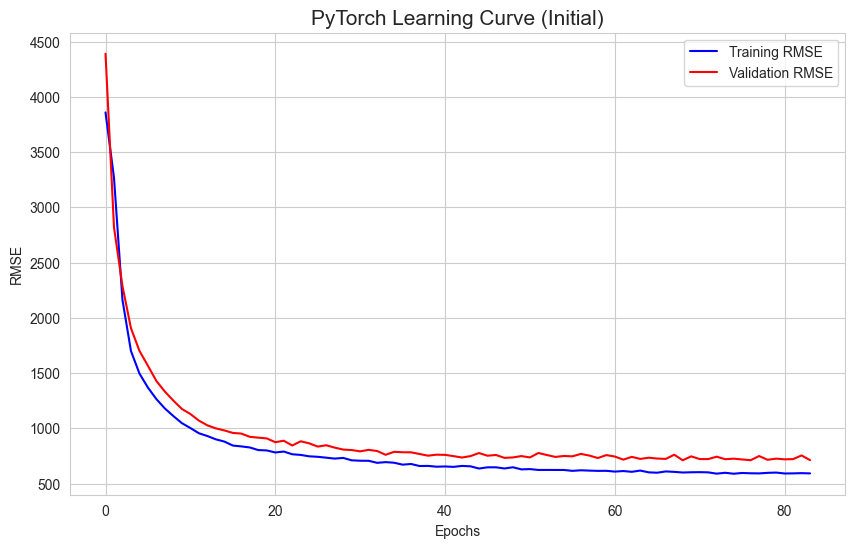

Initial Model Test RMSE: 1155.54


In [5]:
# --- MODEL ARCHITECTURE ---
class RiceYieldNN(nn.Module):
    def __init__(self, input_dim, n_layers=2, units=64, dropout=0.1):
        super(RiceYieldNN, self).__init__()
        layers = []
        in_dim = input_dim
        
        for _ in range(n_layers):
            layers.append(nn.Linear(in_dim, units))
            layers.append(nn.ReLU())
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            in_dim = units
            
        layers.append(nn.Linear(in_dim, 1)) # Output
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# --- TRAINING HELPER FUNCTION ---
def train_model(model, train_loader, X_val, y_val, epochs=150, lr=0.001, patience=15, verbose=True):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    history = {'train_rmse': [], 'val_rmse': []}
    best_val_rmse = float('inf')
    patience_counter = 0
    best_weights = None
    
    for epoch in range(epochs):
        model.train()
        batch_losses = []
        
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
            
        # Validation phase
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val).item()
            val_rmse = np.sqrt(val_loss)
            
        avg_train_rmse = np.sqrt(np.mean(batch_losses))
        
        history['train_rmse'].append(avg_train_rmse)
        history['val_rmse'].append(val_rmse)
        
        # Early Stopping
        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            best_weights = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            if verbose: print(f"Early stopping at epoch {epoch+1}")
            break
            
    if best_weights:
        model.load_state_dict(best_weights)
        
    return history

# --- INITIAL TRAINING ---
train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader_init = DataLoader(train_dataset, batch_size=32, shuffle=True)

model_init = RiceYieldNN(input_dim=X_train_t.shape[1], units=64, n_layers=2).to(device)

print("Training Initial PyTorch Model...")
hist_init = train_model(model_init, train_loader_init, X_val_t, y_val_t)

# Plot Learning Curve
plt.figure(figsize=(10, 6))
plt.plot(hist_init['train_rmse'], label='Training RMSE', color='blue')
plt.plot(hist_init['val_rmse'], label='Validation RMSE', color='red')
plt.title('PyTorch Learning Curve (Initial)', fontsize=15)
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

# Evaluate on Test
model_init.eval()
with torch.no_grad():
    y_pred_init = model_init(X_test_t).cpu().numpy()
rmse_init = np.sqrt(mean_squared_error(y_test_raw, y_pred_init))
print(f"Initial Model Test RMSE: {rmse_init:.2f}")

### 5. Optuna Hyperparameter Optimization
We optimize the Neural Network architecture (Layers, Units, Dropout) and training parameters (LR, Batch Size).

In [11]:
# --- OPTUNA OBJECTIVE FUNCTION ---
def objective(trial):
    # 1. Suggest Hyperparameters
    n_layers = trial.suggest_int('n_layers', 1, 4)
    units = trial.suggest_int('units', 32, 256, step=32)
    dropout = trial.suggest_float('dropout', 0.0, 0.4)
    lr = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32, 64])
    
    # 2. Create DataLoader for this trial
    dataset = TensorDataset(X_train_t, y_train_t)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # 3. Initialize Model
    model = RiceYieldNN(
        input_dim=X_train_t.shape[1],
        n_layers=n_layers,
        units=units,
        dropout=dropout
    ).to(device)
    
    # 4. Train (RMSE minimization)
    history = train_model(
        model, loader, 
        X_val_t, y_val_t, 
        epochs=100, 
        lr=lr, 
        patience=10, 
        verbose=False
    )
    
    # Return best validation RMSE achieved
    return min(history['val_rmse'])

# --- RUN OPTIMIZATION ---
study = optuna.create_study(direction='minimize', study_name='Rice_Yield_PT')
study.optimize(objective, n_trials=20)

print("\nBest Parameters found:")
print(study.best_params)

[I 2025-11-26 21:08:22,890] A new study created in memory with name: Rice_Yield_PT
[I 2025-11-26 21:08:24,584] Trial 0 finished with value: 680.850089043102 and parameters: {'n_layers': 2, 'units': 192, 'dropout': 0.267075066691453, 'learning_rate': 0.004629005842937136, 'batch_size': 32}. Best is trial 0 with value: 680.850089043102.
[I 2025-11-26 21:08:29,846] Trial 1 finished with value: 693.4641753544303 and parameters: {'n_layers': 2, 'units': 160, 'dropout': 0.14593028634693828, 'learning_rate': 0.0004066218499164039, 'batch_size': 32}. Best is trial 0 with value: 680.850089043102.
[I 2025-11-26 21:08:35,463] Trial 2 finished with value: 708.2328360080462 and parameters: {'n_layers': 3, 'units': 256, 'dropout': 0.33913268342426117, 'learning_rate': 0.006069247271287209, 'batch_size': 16}. Best is trial 0 with value: 680.850089043102.
[I 2025-11-26 21:08:50,529] Trial 3 finished with value: 601.0718811007549 and parameters: {'n_layers': 2, 'units': 192, 'dropout': 0.31900863831458


Best Parameters found:
{'n_layers': 4, 'units': 96, 'dropout': 0.19460558764690342, 'learning_rate': 0.0010750380305116986, 'batch_size': 8}


### 6. Optuna Visualization
Visualizing the tuning process to understand parameter importance and convergence.

In [13]:
# --- OPTUNA VISUALIZATIONS ---
name = "Rice_Yield_PyTorch"

# 1. Optimization History
fig = plot_optimization_history(study)
fig.update_layout(title=f'{name} Optimization History', width=900, height=500)
fig.show()

# 2. Parallel Coordinate (Hyperparameter Relationships)
fig = plot_parallel_coordinate(study)
fig.update_layout(title=f'{name} Parallel Coordinate Plot', width=900, height=500)
fig.show()

# 3. Slice Plot (Individual Parameter impact)
fig = plot_slice(study)
fig.update_layout(title=f'{name} Slice Plot', width=900, height=500)
fig.show()

# 4. Parameter Importance
try:
    fig = plot_param_importances(study)
    fig.update_layout(title=f'{name} Hyperparameter Importance', width=900, height=500)
    fig.show()
except (ValueError, RuntimeError) as e:
    print(f'Could not plot parameter importance: {e}')

### 7. Tuned Model Training
Retraining the model using the best parameters found on the full history (Train + Validation).

In [14]:
# 1. Prepare Full Data (Train + Val)
X_train_full_raw = pd.concat([X_train_raw, X_val_raw])
y_train_full_raw = np.concatenate([y_train_raw, y_val_raw])

# Re-scale on full training data
X_train_full_np = scaler.fit_transform(imputer.fit_transform(X_train_full_raw))
X_test_final_np = scaler.transform(imputer.transform(X_test_raw))

# Convert to Tensor
X_train_full_t, y_train_full_t = to_tensor(X_train_full_np, y_train_full_raw, device)
X_test_final_t, _ = to_tensor(X_test_final_np, y_test_raw, device)

# 2. Get Best Params
best_params = study.best_params.copy()
batch_size = best_params.pop('batch_size')
lr = best_params.pop('learning_rate')

# 3. Create Full DataLoader
full_dataset = TensorDataset(X_train_full_t, y_train_full_t)
full_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=True)

# 4. Build Final Model
final_model = RiceYieldNN(input_dim=X_train_full_t.shape[1], **best_params).to(device)

# 5. Train on Full Data (No validation set for early stopping, we train for fixed epochs based on study)
print("Training Final Model on Full Data...")
optimizer = optim.Adam(final_model.parameters(), lr=lr)
criterion = nn.MSELoss()

final_model.train()
for epoch in range(150): # Train for sufficient epochs
    for inputs, targets in full_loader:
        optimizer.zero_grad()
        outputs = final_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

# 6. Final Prediction
final_model.eval()
with torch.no_grad():
    y_pred_final = final_model(X_test_final_t).cpu().numpy()

rmse_final = np.sqrt(mean_squared_error(y_test_raw, y_pred_final))
r2_final = r2_score(y_test_raw, y_pred_final)

Training Final Model on Full Data...


### 8. Final Results & Plots

--- Final Performance Report (Test Set) ---
Baseline Model: RMSE=527.17, R2=0.9436
Initial Model:  RMSE=1155.54
Tuned Model:    RMSE=513.49, R2=0.9465 (RMSE Improved 2.59%)


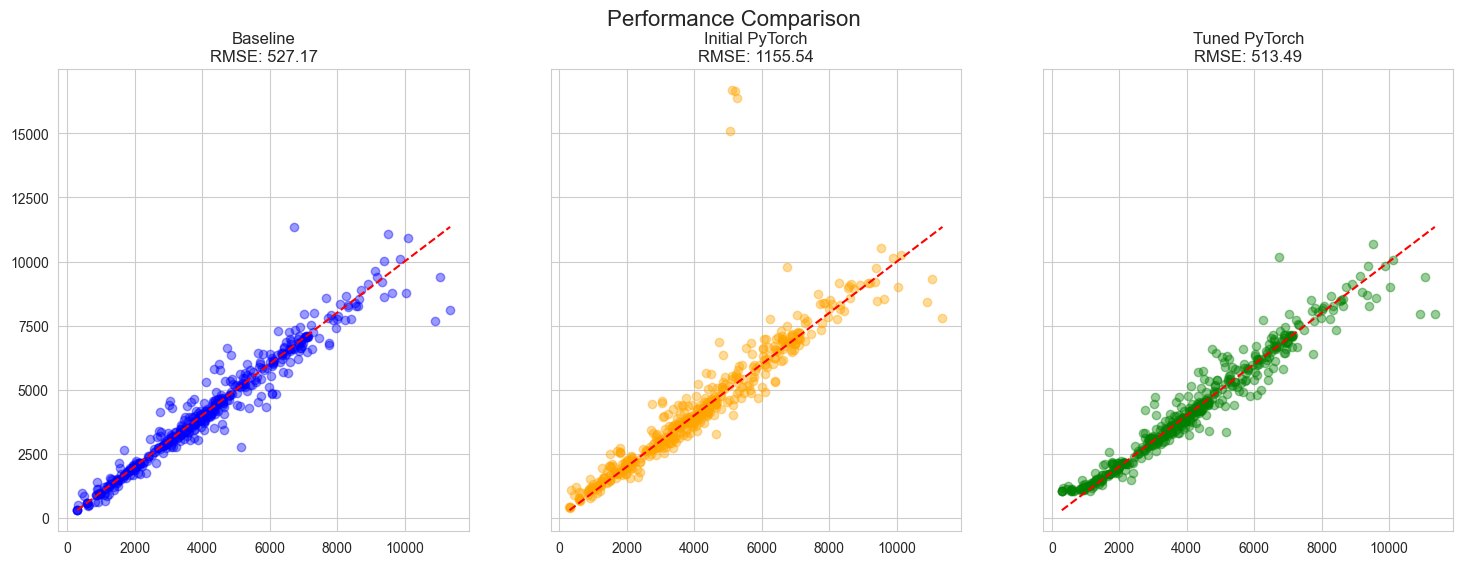

In [9]:
# Calculate Improvement %
imp_final = (rmse_baseline - rmse_final) / rmse_baseline * 100

print("--- Final Performance Report (Test Set) ---")
print(f"Baseline Model: RMSE={rmse_baseline:.2f}, R2={r2_baseline:.4f}")
print(f"Initial Model:  RMSE={rmse_init:.2f}")
print(f"Tuned Model:    RMSE={rmse_final:.2f}, R2={r2_final:.4f} (RMSE Improved {imp_final:.2f}%)")

# --- PLOTTING RESULTS ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

y_test_flat = y_test_raw.flatten()
y_pred_final_flat = y_pred_final.flatten()

min_val = min(y_test_flat.min(), y_pred_final_flat.min())
max_val = max(y_test_flat.max(), y_pred_final_flat.max())

# 1. Baseline Plot
axes[0].scatter(y_test_clean, y_pred_clean, alpha=0.4, color='blue')
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--')
axes[0].set_title(f'Baseline\nRMSE: {rmse_baseline:.2f}')

# 2. Initial Model Plot
axes[1].scatter(y_test_raw, y_pred_init, alpha=0.4, color='orange')
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--')
axes[1].set_title(f'Initial PyTorch\nRMSE: {rmse_init:.2f}')

# 3. Tuned Model Plot
axes[2].scatter(y_test_raw, y_pred_final, alpha=0.4, color='green')
axes[2].plot([min_val, max_val], [min_val, max_val], 'r--')
axes[2].set_title(f'Tuned PyTorch\nRMSE: {rmse_final:.2f}')

plt.suptitle('Performance Comparison', fontsize=16)
plt.show()

Calculating Permutation Importance...


/var/folders/zn/lrmslqwn0g3_slr732tvb0zw0000gn/T/ipykernel_11095/3661777223.py:42: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




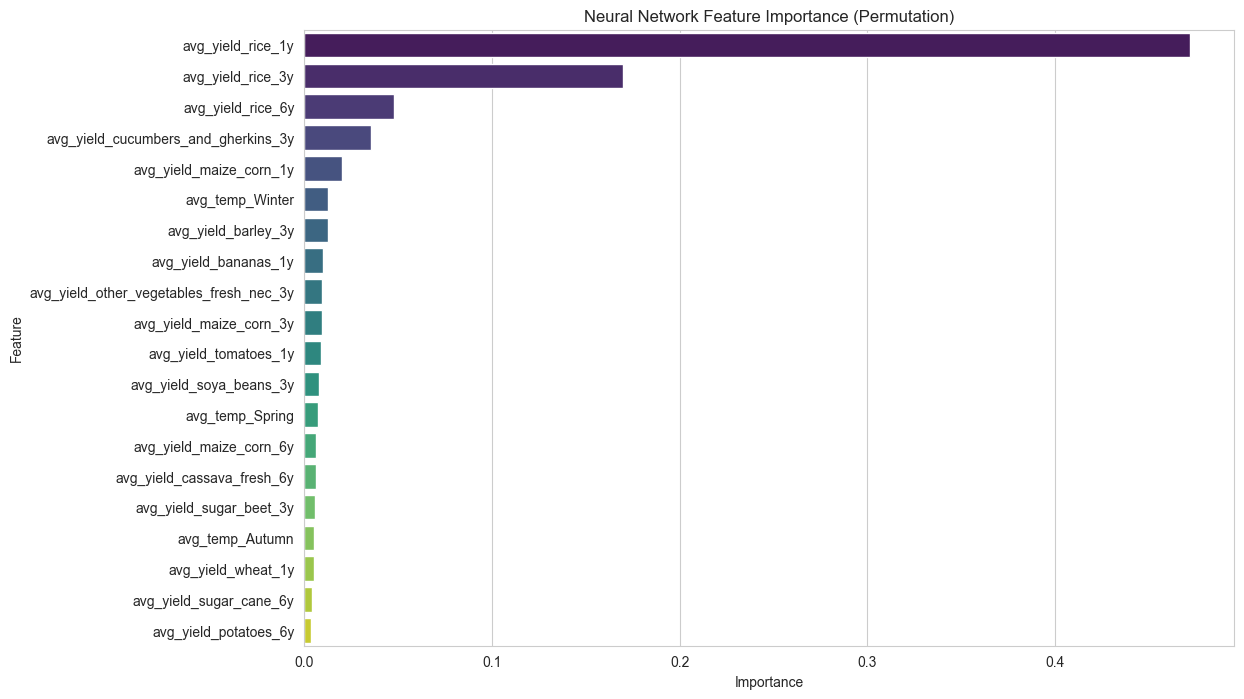

In [18]:
# --- FEATURE IMPORTANCE (Permutation Importance) ---
# Neural Networks don't have built-in feature importance, so we use Permutation Importance.

class PyTorchWrapper:
    def __init__(self, model):
        self.model = model
        
    # Scikit-learn requires a fit method to validate the estimator, 
    # even though we won't use it here.
    def fit(self, X, y=None):
        return self

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            # Ensure X is a tensor
            if isinstance(X, np.ndarray):
                inputs = torch.tensor(X, dtype=torch.float32).to(device)
            else:
                inputs = X.to(device)
            preds = self.model(inputs)
        return preds.cpu().numpy().flatten()

wrapped_model = PyTorchWrapper(final_model)

print("Calculating Permutation Importance...")
result = permutation_importance(
    wrapped_model, 
    X_test_final_np, 
    y_test_raw.flatten(), 
    n_repeats=5, 
    random_state=42, 
    scoring='r2'
)

fi_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=fi_df, palette='viridis')
plt.title('Neural Network Feature Importance (Permutation)')
plt.show()